In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)


In [2]:
# 0) Generate Synthetic Dataset

"""
Purpose: Create a simple, nonlinear dataset for classification.
Why use it: KNN performs well on low-dimensional data with local boundaries.
When to use: Demos and intuition-building on neighborhood-based learning.
"""
X, y = make_moons(n_samples=300, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


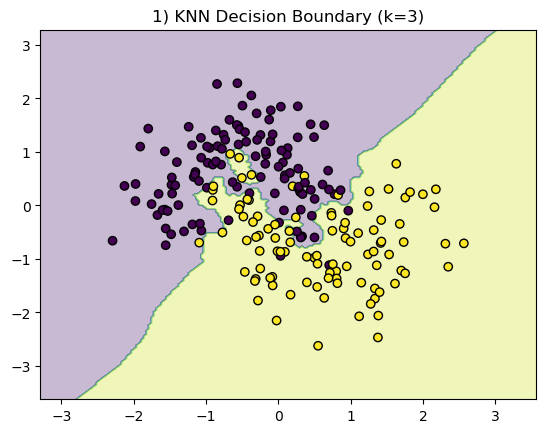

In [3]:
# 1) Decision Boundary Visualization

"""
- Plot name: KNN Decision Boundary
- Purpose: Visualize how KNN separates feature space.
- Why use it: Shows local neighborhood-based classification in action.
- When to use: Understanding bias-variance tradeoff (k small → complex, k large → smooth).
- X-axis / Y-axis: Two input features.
"""
def plot_decision_boundary(k=3):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    
    x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
    y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolor='k')
    plt.title(f"1) KNN Decision Boundary (k={k})")
    plt.show()

plot_decision_boundary(3)

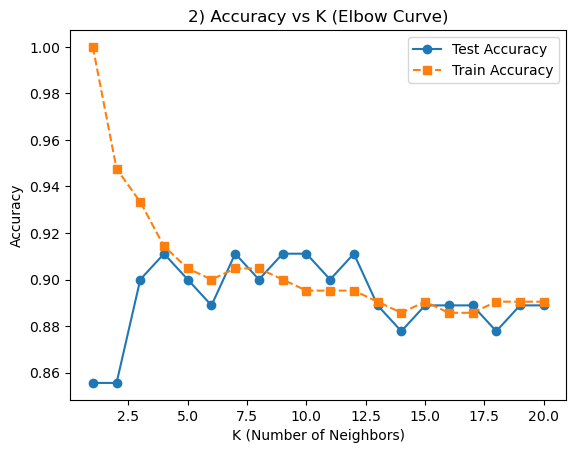

In [4]:
# 2) Accuracy vs K (Elbow Method)

"""
- Plot name: Accuracy vs K
- Purpose: Determine the best number of neighbors (K) by tracking accuracy.
- Why use it: Balance bias (small k) vs variance (large k).
- When to use: Hyperparameter tuning.
"""
train_acc, test_acc = [], []
ks = range(1, 21)

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    train_acc.append(model.score(X_train_scaled, y_train))
    test_acc.append(model.score(X_test_scaled, y_test))

plt.plot(ks, test_acc, marker='o', label='Test Accuracy')
plt.plot(ks, train_acc, marker='s', linestyle='--', label='Train Accuracy')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("2) Accuracy vs K (Elbow Curve)")
plt.legend()
plt.show()

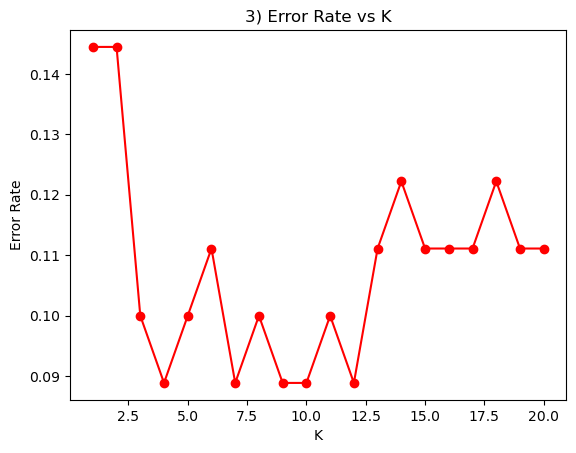

In [5]:
# 3) Error Rate vs K

"""
- Plot name: Error Rate vs K
- Purpose: Visualize misclassification trends with K.
- Why use it: Highlights where overfitting or underfitting happens.
- When to use: After accuracy curve for clearer tradeoff.
"""
error_rate = [1 - acc for acc in test_acc]
plt.plot(ks, error_rate, marker='o', color='red')
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.title("3) Error Rate vs K")
plt.show()

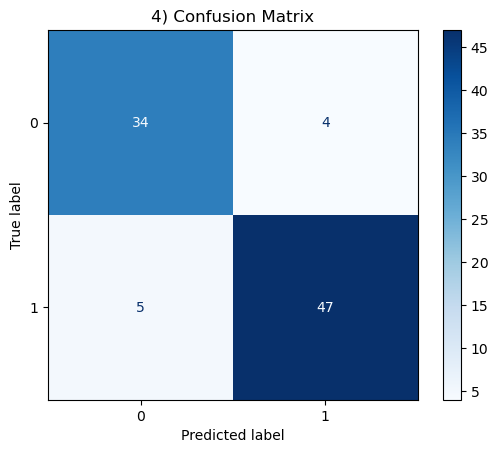

In [6]:
# 4) Confusion Matrix Heatmap

"""
- Plot name: Confusion Matrix
- Purpose: Assess class-wise prediction strengths and weaknesses.
- Why use it: Identify where the model confuses specific labels.
- When to use: After final model predictions.
"""
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("4) Confusion Matrix")
plt.show()


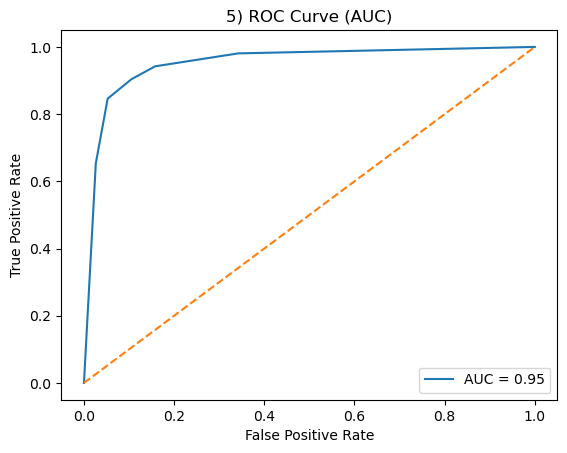

In [7]:
# 5) ROC Curve & AUC

"""
- Plot name: ROC Curve
- Purpose: Evaluate classifier’s sensitivity-specificity tradeoff.
- Why use it: Measures true positive rate vs false positive rate.
- When to use: Binary classification with probability outputs.
"""
y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("5) ROC Curve (AUC)")
plt.legend()
plt.show()

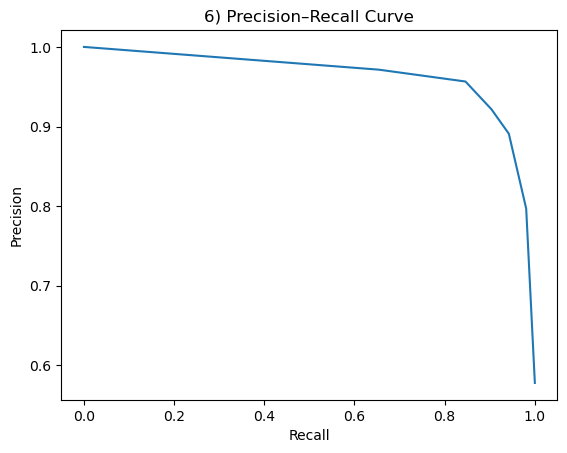

In [8]:
# 6) Precision–Recall Curve

"""
- Plot name: Precision–Recall Curve
- Purpose: Evaluate tradeoff between precision and recall.
- Why use it: Particularly useful for imbalanced datasets.
- When to use: To identify thresholds balancing false positives vs false negatives.
"""
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("6) Precision–Recall Curve")
plt.show()

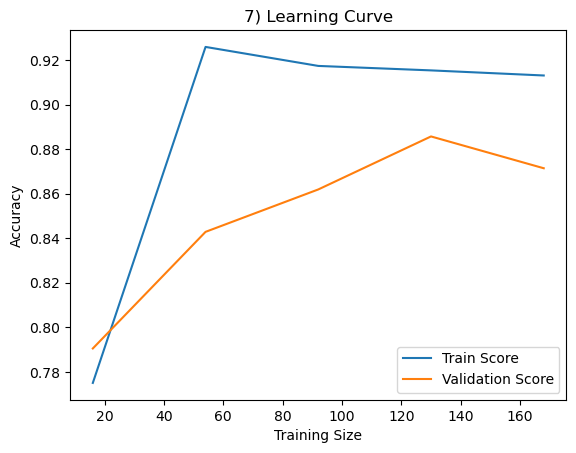

In [9]:
# 7) Learning Curve

"""
- Plot name: Learning Curve
- Purpose: Assess how training size affects performance.
- Why use it: Diagnose overfitting or underfitting trends.
- When to use: Before scaling dataset in production or training large models.
"""
train_sizes, train_scores, test_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=5), X_train_scaled, y_train,
    cv=5, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("7) Learning Curve")
plt.legend()
plt.show()

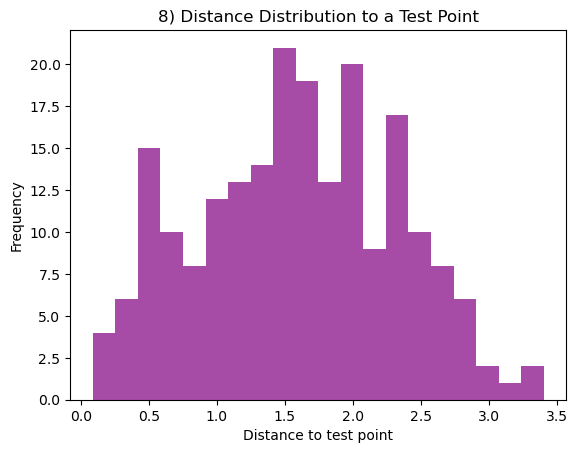

In [10]:
# 8) Distance Distribution for a Test Point

"""
- Plot name: Distance Distribution (for one test sample)
- Purpose: Visualize how distances to neighbors affect classification.
- Why use it: Explains local decision basis in KNN.
- When to use: Debugging or explaining specific predictions.
"""
point = X_test_scaled[0]
dists = np.sqrt(((X_train_scaled - point) ** 2).sum(axis=1))

plt.hist(dists, bins=20, color='purple', alpha=0.7)
plt.xlabel("Distance to test point")
plt.ylabel("Frequency")
plt.title("8) Distance Distribution to a Test Point")
plt.show()

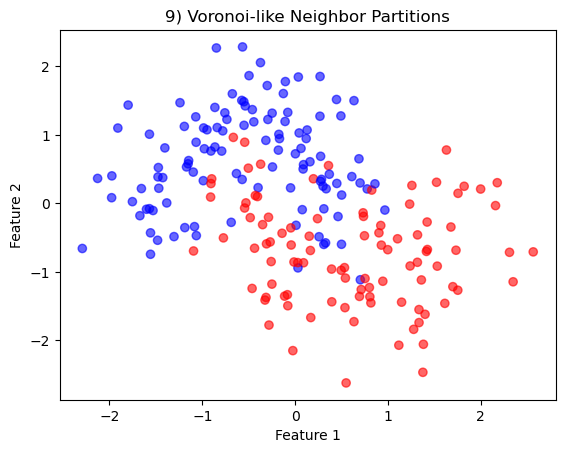

In [11]:
# 9) Voronoi-style Neighbor Regions

"""
- Plot name: Voronoi-style KNN Partition
- Purpose: Conceptually show how each training sample defines a region.
- Why use it: Illustrate the spatial intuition of KNN boundaries.
- When to use: Teaching and conceptual understanding.
"""
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='bwr', alpha=0.6)
plt.title("9) Voronoi-like Neighbor Partitions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()